<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut09_to_fill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial 9 - Spectral Shaping
23.12.2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

### Problem 7.1
* 1. Implement the PSD estimator (7.8).

In [2]:
# Calculate PSD according to empirical formula
def PSD(x):
    num_seq = x.shape[0]
    len_seq = x.shape[1]
    x_f = np.fft.fft(x)
    # Your code here
    PSD = np.abs(x_f)**2/len_seq
    return np.mean(PSD, axis=0)

* 2. Sample the length $n = 10 000$ time signal $x$ with independent normal Gaussian
entries. Plot its PSD for $n_{seq} = \{10, 100, 1000\}$.

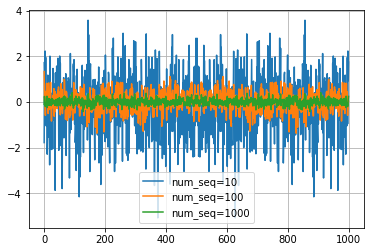

P_t=1.0013, P_f=1.0013


In [3]:
len_seq = 1000
for num_seq in [10, 100, 1000]:
    x = np.random.randn(num_seq, len_seq)
    S_xx = PSD(x)
    P_t = np.mean(x**2)
    P_f = np.mean(S_xx)
    plt.plot(10*np.log10(S_xx), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()
print(f'P_t={P_t :.4f}, P_f={P_f :.4f}')    

* 3. Consider now the signal $y$ with $$y_i = x_i + 0.5  x(i-1) \mod n$$

     Are the entries of $y_i$ independent?
 
 
 
* 4. Plot the PSD of $y$ for $n_{seq} = \{10, 100, 1000\}$.

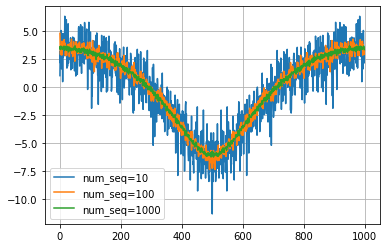

In [4]:
alpha = 0.5
for num_seq in [10, 100, 1000]:
    x = np.random.randn(num_seq, len_seq)
    # Your code here
    y = x + alpha * np.roll(x, 1)
    S_yy = PSD(y)
    plt.plot(10*np.log10(S_yy), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()

* 5. Compare the plots of 2. and 4. with the ones obtained with scipy.signal.welch

In [5]:
from scipy import signal

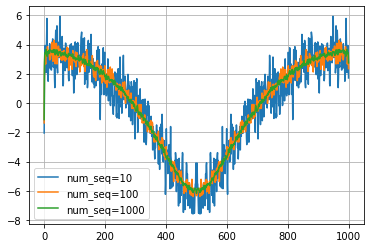

In [6]:
for num_seq in [10, 100, 1000]:
    #print(num_seq)
    x = np.random.randn(len_seq*num_seq)
    y = x + alpha * np.roll(x, 1)
    # Your code here
    _, Syy = signal.welch(y, nperseg=len_seq, return_onesided=False)
    plt.plot(10*np.log10(Syy), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()    

### Problem 7.2 - Filter Design by End-to-End Training

* 1. Carry out the end-to-end filter design described in Section 7.4 and plot the PSDs of the filtered signals.
* 2. Remove the low pass filter from the channel. Retrain the system and plot the PSDs of the filtered signals.
* 3. Exchange the low pass filter in the channel by interference as described in Section 7.1.2. Retrain the system and plot the PSDs of the filtered signals.
* 4. Exchange the low pass filter in the channel by the pilot tone as described in Section 7.1.3. Retrain the system and plot the PSDs of the filtered signals.

In [7]:
import torch
import time

##### Auxiliary functions

In [8]:
def downsample_td(signal, down):
    return down * signal[::down]

def upsample_td(signal, up):
    _signal = torch.zeros(len(signal) * up, dtype=signal.dtype)
    _signal[::up] = signal
    return _signal

def normalize(x):
    P = torch.mean(x**2)
    return x / torch.sqrt(P)

def get_filter_response(filt, fs, nperseg=100):
    x = torch.zeros(fs * nperseg)
    x[nperseg//2] = 1.
    h = tx_filter(x).detach().numpy()
    h = 1 / np.sqrt(np.sum(h**2)) * h
    Shh_dB = 10*np.log10(np.abs(np.fft.fft(h))**2)
    return h, Shh_dB

##### Communication system

In [10]:
def mapper(n, M):
    a = np.random.choice(range(M), n)
    alphabet = np.arange(-(M-1), M, 2)
    x = alphabet[a]
    return torch.tensor(a), torch.tensor(x).float()

class Demapper(torch.nn.Module):
    def __init__(self, M, redundant=False):
        super().__init__()
        self.redundant = redundant
        if self.redundant:
            self.lin1 = torch.nn.Linear(1, 2 * M)
            self.lin2 = torch.nn.Linear(2 * M, M)
        else:
            self.lin = torch.nn.Linear(1, M)
        
    def forward(self, y):
        if self.redundant:
            return self.lin2(self.lin1(y))
        else:
            return self.lin(y)

class LinearFilter(torch.nn.Module):
    def __init__(self, num_taps):
        super().__init__()
        self.conv = torch.nn.Conv1d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=num_taps,
                                    padding='same',
                                    bias=False)
    def forward(self, y):
        y = self.conv(y.reshape(1, 1, -1)).reshape(-1)
        return 1 / torch.sqrt(torch.mean(y**2)) * y
    
def transmitter(batch_size,
                M,
                ovs_factor,
                tx_filter):
    a, x = mapper(batch_size, M) # M-ASK mapper
    power_x = torch.mean(x**2)
    
    u = upsample_td(x, ovs_factor)
    
    y_tx = tx_filter(u) # transmit filter g
    y_tx = normalize(y_tx)
    
    return a, x, u, y_tx, power_x

def receiver(y_ch, power_x, rx_filter, ovs_factor, demapper):
    y_rx = rx_filter(y_ch.reshape(1, 1, -1)).reshape(-1)
    y_rx = normalize(y_rx)
    
    d = downsample_td(y_rx, ovs_factor)
    
    power_d = torch.mean(d**2)
    d = torch.sqrt(power_x / power_d) * d
    
    l = demapper(d.reshape(-1, 1))
    return y_rx, d, l

##### Plotting functions

In [11]:
def scatterplot(x, d, show=True):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy().reshape(-1)
    if isinstance(d, torch.Tensor):
        d = d.detach().numpy().reshape(-1)
    plt.scatter(d[::2], d[1::2], s=1, label='d')
    plt.scatter(x[::2], x[1::2], s=1, label='x')
    plt.grid()
    plt.xlim((-8, 8))
    plt.ylim((-8, 8))
    plt.xticks(np.arange(-8, 9, 2))
    plt.yticks(np.arange(-8, 9, 2))
    plt.gca().set_aspect('equal')
    if show:
        plt.show()

def PSD(x, label, fs, nperseg=100, show=False, fftshift=False):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy().reshape(-1)
    f, Pxx = signal.welch(x, nperseg=nperseg * fs, return_onesided=False, fs=fs)
    if not fftshift:
        plt.plot(10*np.log10(Pxx), label=label)
    else:
        plt.plot(np.fft.fftshift(10*np.log10(Pxx)), linestyle='dashed', label=label)
    plt.grid()
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('power spectral density')
    if show:
        plt.show()

#### Low pass filter channel

In [12]:
def get_rc_fd(filter_length, rolloff, samples_per_symbol):
    assert filter_length % 2 == 0, 'filter_length should be even'
    f = np.arange(-0.5, 0.5, 1 / filter_length)
    T = samples_per_symbol
    return _rc_fd(rolloff, T, f)

def _rc_fd(rolloff, T, f):
    Hf = np.cos(np.pi * T / 2 / rolloff *(np.abs(f) - (1 - rolloff) / 2 / T))**2
    idx = np.logical_and((1 - rolloff) / 2 / T < np.abs(f), np.abs(f) <= (1 + rolloff) / 2 / T)
    filter_fd = np.zeros_like(f)
    filter_fd[idx] = Hf[idx]
    idx1 = np.abs(f) <= (1 - rolloff) / 2 / T
    filter_fd[idx1] = 1.
    return np.fft.fftshift(filter_fd)

def filter_circ(signal, filter_fd):
    s_fd = torch.fft.fft(signal)
    signal_td = torch.fft.ifft(s_fd * filter_fd)
    return torch.real(signal_td).float()

def get_lpf(num_samples):
    filter_fd = torch.tensor(get_rc_fd(num_samples, 
                             rolloff=0.2, 
                             samples_per_symbol=8/5))
    return filter_fd

def channel_lpf(y, filter_fd, noise_variance):
    y_ch = filter_circ(y, filter_fd)
    return y_ch + np.sqrt(noise_variance) * torch.randn(y_ch.shape)

In [17]:
n_epochs = 100_000
batch_size = 1_000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)
lpf_fd = get_lpf(ovs_factor * batch_size)

# Your code here
# We want to train tx filter, rx filter and demapper
optimizer = torch.optim.Adam(list(tx_filter.parameters()) + list(rx_filter.parameters()) + list(demapper.parameters()), lr=0.01)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    # Your code here
    filter_fd = get_lpf(batch_size * ovs_factor)
    y_ch = channel_lpf(y_tx,filter_fd,noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_lpf(y_tx, 
                           get_lpf(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 1265) XE=0.0537bits
(Epoch 2578) XE=0.2497bits
(Epoch 3914) XE=0.1487bits
(Epoch 5250) XE=0.1416bits
(Epoch 6625) XE=0.3630bits
(Epoch 7983) XE=0.0665bits
(Epoch 9349) XE=0.1157bits
(Epoch 10688) XE=0.1359bits
(Epoch 12030) XE=0.1072bits
(Epoch 13393) XE=0.1234bits
(Epoch 14753) XE=0.1203bits
(Epoch 16104) XE=0.0895bits
(Epoch 17483) XE=0.1348bits
(Epoch 18872) XE=0.1072bits
(Epoch 20275) XE=0.0272bits
(Epoch 21733) XE=0.0287bits
(Epoch 23176) XE=0.0222bits
(Epoch 24614) XE=0.0320bits
(Epoch 26064) XE=0.0214bits
(Epoch 27487) XE=0.0227bits
(Epoch 28887) XE=0.0405bits
(Epoch 30314) XE=0.0366bits
(Epoch 31673) XE=0.0337bits
(Epoch 33040) XE=0.0224bits
(Epoch 34427) XE=0.1189bits
(Epoch 35807) XE=0.1621bits
(Epoch 37143) XE=0.0700bits
(Epoch 38501) XE=0.0799bits
(Epoch 39906) XE=0.4288bits
(Epoch 41319) XE=0.0405bits
(Epoch 42785) XE=0.0203bits
(Epoch 44238) XE=0.0225bits
(Epoch 45646) XE=0.0218bits
(Epoch 47047) XE=0.0677bits
(Epoch 48475) XE=0.0302bits
(Epoch 49925) XE=0.1607bits

In [18]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
filter_fd = get_lpf(100_000 * ovs_factor)
y_ch = channel_lpf(y_tx, filter_fd, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

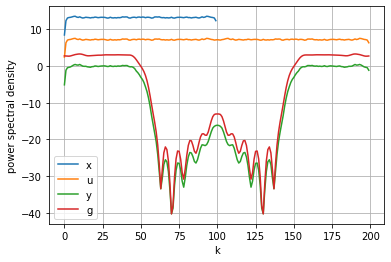

In [19]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


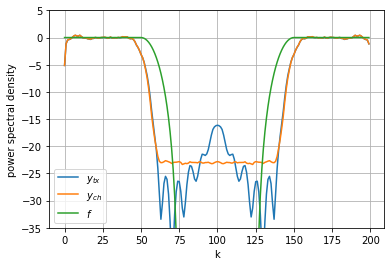

In [20]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
lpf = get_lpf(200)
plt.plot(10*np.log10(np.abs(lpf)**2), label=r'$f$')
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

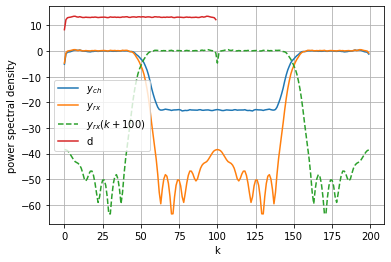

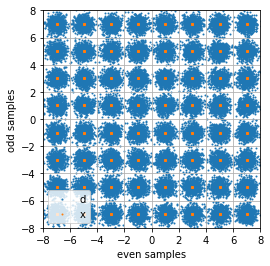

In [21]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Without low-pass filter

In [22]:
def channel_awgn(y, noise_variance):
    return y + np.sqrt(noise_variance) * torch.randn(y.shape)

In [44]:
# Your code here
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.05
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)
lpf_fd = get_lpf(ovs_factor * batch_size)

# Your code here
# We want to train tx filter, rx filter and demapper
optimizer = torch.optim.Adam(list(tx_filter.parameters()) + list(rx_filter.parameters()) + list(demapper.parameters()), lr=0.01)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    # Your code here
    y_ch = channel_awgn(y_tx,noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_lpf(y_tx, 
                           get_lpf(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()



(Epoch 1721) XE=0.4881bits
(Epoch 3397) XE=0.5204bits
(Epoch 5074) XE=0.5400bits
(Epoch 6794) XE=0.4779bits
(Epoch 8490) XE=0.5673bits
(Epoch 10145) XE=0.5103bits
(Epoch 11901) XE=0.5181bits
(Epoch 13595) XE=0.5349bits
(Epoch 15318) XE=0.5199bits
(Epoch 17064) XE=0.5417bits
(Epoch 18793) XE=0.5020bits
(Epoch 20558) XE=0.5248bits
(Epoch 22334) XE=0.5230bits
(Epoch 24080) XE=0.5147bits
(Epoch 25832) XE=0.5436bits
(Epoch 27588) XE=0.5711bits
(Epoch 29333) XE=0.4833bits
(Epoch 31055) XE=0.5607bits
(Epoch 32816) XE=0.5270bits
(Epoch 34535) XE=0.5800bits
(Epoch 36240) XE=0.4939bits
(Epoch 37974) XE=0.5102bits
(Epoch 39747) XE=0.5642bits
(Epoch 41526) XE=0.4955bits
(Epoch 43291) XE=0.5334bits
(Epoch 45047) XE=0.5238bits
(Epoch 46791) XE=0.5566bits
(Epoch 48510) XE=0.5266bits
(Epoch 50224) XE=0.4845bits
(Epoch 51983) XE=0.5121bits
(Epoch 53756) XE=0.4897bits
(Epoch 55501) XE=0.5830bits
(Epoch 57249) XE=0.4586bits
(Epoch 58970) XE=0.4906bits
(Epoch 60695) XE=0.5369bits
(Epoch 62435) XE=0.5077bi

In [45]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
y_ch = channel_awgn(y_tx, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

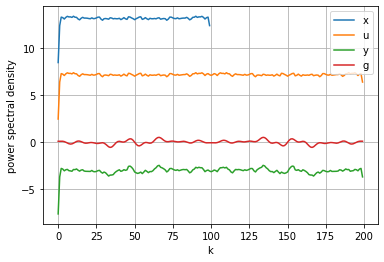

In [46]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

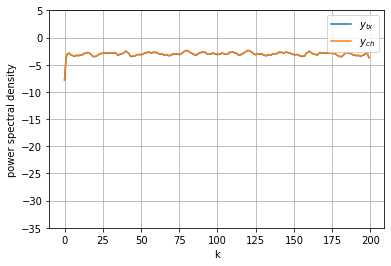

In [26]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

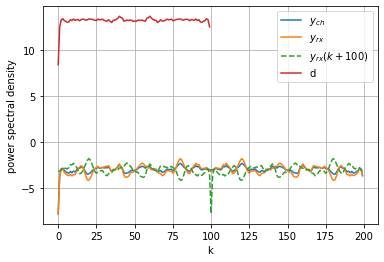

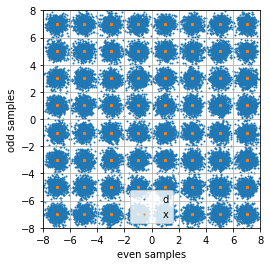

In [27]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Interference Channel

In [28]:
def filter_circ(signal, filter_fd):
    s_fd = torch.fft.fft(signal)
    signal_td = torch.fft.ifft(torch.fft.fftshift(s_fd * filter_fd))
    return torch.real(signal_td).float()

def get_rc(num_samples):
    filter_fd = torch.tensor(get_rc_fd(num_samples, 
                             rolloff=0.2, 
                             samples_per_symbol=2))
    return filter_fd

def channel_interf(y, filter_fd, noise_variance):
    interference_fd = torch.randn(y.shape)
    return y + filter_circ(interference_fd, filter_fd) + np.sqrt(noise_variance) * torch.randn(y.shape)

In [29]:
# Your code here
# Your code here
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)
lpf_fd = get_lpf(ovs_factor * batch_size)

# Your code here
# We want to train tx filter, rx filter and demapper
optimizer = torch.optim.Adam(list(tx_filter.parameters()) + list(rx_filter.parameters()) + list(demapper.parameters()), lr=0.01)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    # Your code here
    filter_fd = get_rc(batch_size * ovs_factor)
    y_ch = channel_interf(y_tx, filter_fd, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_lpf(y_tx, 
                           get_lpf(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 1459) XE=0.1621bits
(Epoch 2982) XE=0.0965bits
(Epoch 4477) XE=0.0993bits
(Epoch 6009) XE=0.1235bits
(Epoch 7579) XE=0.0779bits
(Epoch 9134) XE=0.0665bits
(Epoch 10650) XE=0.0781bits
(Epoch 12180) XE=0.1553bits
(Epoch 13649) XE=0.0714bits
(Epoch 15094) XE=0.1364bits
(Epoch 16635) XE=0.1637bits
(Epoch 18177) XE=0.1360bits
(Epoch 19694) XE=0.0715bits
(Epoch 21224) XE=0.0894bits
(Epoch 22711) XE=0.0705bits
(Epoch 24164) XE=0.0775bits
(Epoch 25610) XE=0.0692bits
(Epoch 27058) XE=0.0700bits
(Epoch 28500) XE=0.0733bits
(Epoch 29927) XE=0.0476bits
(Epoch 31342) XE=0.1226bits
(Epoch 32746) XE=0.0533bits
(Epoch 34159) XE=0.0693bits
(Epoch 35584) XE=0.0714bits
(Epoch 37014) XE=0.0635bits
(Epoch 38459) XE=0.0548bits
(Epoch 39893) XE=0.0608bits
(Epoch 41347) XE=0.0445bits
(Epoch 42767) XE=0.0745bits
(Epoch 44227) XE=0.0743bits
(Epoch 45673) XE=0.0455bits
(Epoch 47071) XE=0.0397bits
(Epoch 48499) XE=0.0503bits
(Epoch 49924) XE=0.0621bits
(Epoch 51302) XE=0.0477bits
(Epoch 52666) XE=0.0625bit

In [30]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
filter_fd = get_rc(100_000 * ovs_factor)
y_ch = channel_interf(y_tx, filter_fd, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

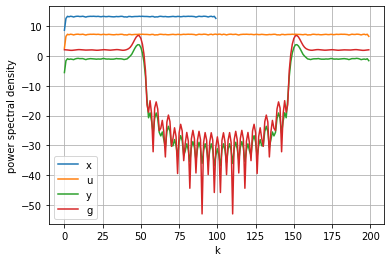

In [31]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

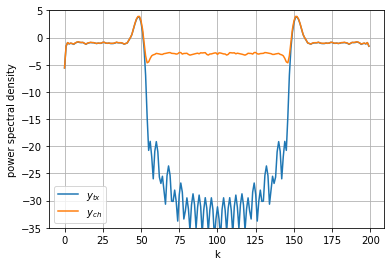

In [32]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

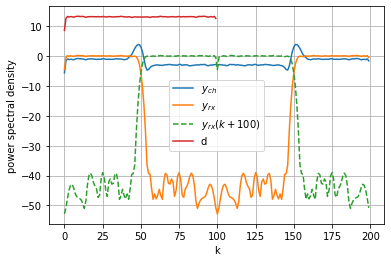

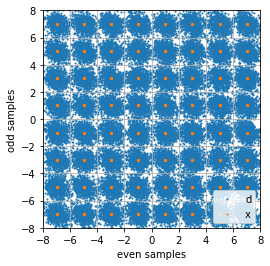

In [33]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Pilot tone

In [34]:
def get_pilot(n, ovs_factor, power):
    tone_fd = np.zeros(n * ovs_factor)
    f = int(0.2 * n)
    tone_fd[f - 1] = 0.1 * n
    tone_fd[f] = n
    tone_fd[f + 1] = 0.1 * n
    phase = np.random.rand()
    tone = np.real(np.fft.ifft(tone_fd * np.exp(2 * np.pi * phase)))
    return np.sqrt(power / np.mean(tone**2)) * tone

def channel_pilot_tone(y, ovs_factor, pilot_power, noise_variance):
    pilot = get_pilot(len(y)//ovs_factor, ovs_factor, pilot_power)
    y_ch = y + torch.tensor(pilot).float()
    return y_ch + np.sqrt(noise_variance) * torch.randn(y_ch.shape)

In [38]:
# Your code here
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)
lpf_fd = get_lpf(ovs_factor * batch_size)

# Your code here
# We want to train tx filter, rx filter and demapper
optimizer = torch.optim.Adam(list(tx_filter.parameters()) + list(rx_filter.parameters()) + list(demapper.parameters()), lr=0.01)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    # Your code here
    y_ch = channel_pilot_tone(y_tx, ovs_factor, 5, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_lpf(y_tx, 
                           get_lpf(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()



(Epoch 1654) XE=0.0629bits
(Epoch 3343) XE=0.1019bits
(Epoch 4954) XE=0.3140bits
(Epoch 6563) XE=0.0349bits
(Epoch 8158) XE=0.0413bits
(Epoch 9752) XE=0.0357bits
(Epoch 11387) XE=0.0910bits
(Epoch 13080) XE=0.0249bits
(Epoch 14821) XE=0.0208bits
(Epoch 16561) XE=0.0116bits
(Epoch 18335) XE=0.0115bits
(Epoch 20074) XE=0.0207bits
(Epoch 21858) XE=0.0148bits
(Epoch 23625) XE=0.0088bits
(Epoch 25380) XE=0.0080bits
(Epoch 27100) XE=0.0067bits
(Epoch 28855) XE=0.0103bits
(Epoch 30589) XE=0.0260bits
(Epoch 32341) XE=0.0253bits
(Epoch 34063) XE=0.0196bits
(Epoch 35778) XE=0.0267bits
(Epoch 37436) XE=0.0107bits
(Epoch 38998) XE=0.0031bits
(Epoch 40639) XE=0.0057bits
(Epoch 42344) XE=0.0247bits
(Epoch 44037) XE=0.0115bits
(Epoch 45773) XE=0.0081bits
(Epoch 47475) XE=0.0276bits
(Epoch 49157) XE=0.0108bits
(Epoch 50851) XE=0.0278bits
(Epoch 52556) XE=0.0150bits
(Epoch 54253) XE=0.0210bits
(Epoch 55954) XE=0.0089bits
(Epoch 57584) XE=0.0054bits
(Epoch 59242) XE=0.0070bits
(Epoch 60887) XE=0.0087bit

In [40]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
y_ch = channel_pilot_tone(y_tx, ovs_factor, 5, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

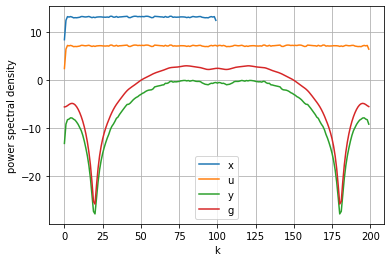

In [41]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

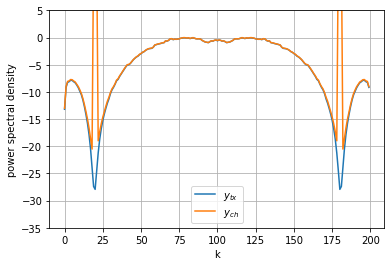

In [42]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

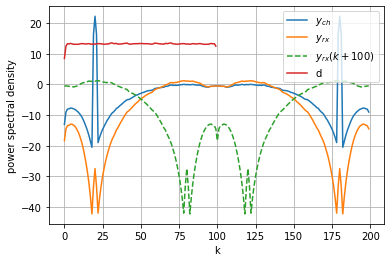

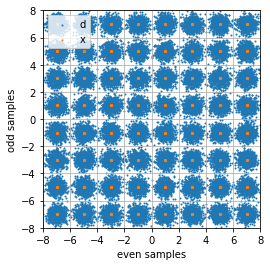

In [43]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()